In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay

In [2]:
heart_data = pd.read_csv("heart_data.csv")
heart_data.head()

,idade,sexo,pressao_sistolica,colesterol_total,batimentos_em_repouso,fumante,diabetico,historico_familiar,atividade_fisica,estresse,doenca_cardiaca
0,67,Masculino,116,240,69,1,0,1,Moderada,Alto,1
1,57,Feminino,108,241,70,0,0,0,Baixa,Baixo,0
2,43,Feminino,126,255,50,0,0,0,Alta,Moderado,0
3,71,Masculino,128,228,74,0,1,0,Moderada,Baixo,0
4,36,Masculino,131,203,73,0,0,0,Alta,Baixo,0


Descrição das Colunas do Dataset

- idade:	Idade da pessoa em anos.
- sexo:	Sexo biológico da pessoa (masculino ou feminino).
- pressao_sistolica:	Valor da pressão arterial sistólica (o maior valor da medição).
- colesterol_total:	Nível total de colesterol no sangue (em mg/dL).
- batimentos_em_repouso:	Frequência cardíaca em repouso (batimentos por minuto).
- fumante:	Indica se a pessoa é fumante (0 = não, 1 = sim).
- diabetico	Indica se a pessoa possui diabetes (0 = não, 1 = sim).
- historico_familiar:	Histórico familiar de doenças cardíacas (0 = não, 1 = sim).
- atividade_fisica:	Nível de atividade física (baixa, moderada ou alta).
- estresse:	Nível de estresse relatado (baixo, moderado ou alto).
- doenca_cardiaca:	Variável alvo: presença de doença cardíaca (0 = não, 1 = sim).

In [3]:
heart_data.describe()

,idade,pressao_sistolica,colesterol_total,batimentos_em_repouso,fumante,diabetico,historico_familiar,doenca_cardiaca
count,7685.000000,7685.000000,7685.000000,7685.000000,7685.000000,7685.000000,7685.000000,7685.000000
mean,52.594014,129.604554,219.722707,74.402993,0.296682,0.149512,0.400781,0.179310
std,13.751472,15.040009,39.961779,9.899317,0.456825,0.356616,0.490089,0.383637
min,29.000000,71.000000,65.000000,38.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,120.000000,193.000000,68.000000,0.000000,0.000000,0.000000,0.000000
50%,53.000000,130.000000,220.000000,75.000000,0.000000,0.000000,0.000000,0.000000
75%,64.000000,140.000000,247.000000,81.000000,1.000000,0.000000,1.000000,0.000000
max,76.000000,181.000000,399.000000,111.000000,1.000000,1.000000,1.000000,1.000000


A seguir estão algumas observações com base nas estatísticas descritivas do dataset:

---

### Variáveis Numéricas

#### **Idade**
- **Média:** 52 anos
- **Intervalo:** 29 a 76 anos
- **Distribuição:** 50% das pessoas têm entre 41 e 64 anos.
- **Insight:** Faixa etária predominante já está em grupos de risco para doenças cardíacas.

#### **Pressão Sistólica**
- **Média:** 129,60 mmHg
- **Desvio Padrão:** 15,04
- **Intervalo:** 71 a 181 mmHg
- **Insight:** Média próxima do limiar de hipertensão. Há casos severos com pressão muito alta.

#### **Colesterol Total**
- **Média:** 219,72 mg/dL
- **Intervalo:** 65 a 399 mg/dL
- **Insight:** Valor médio está acima do recomendado pela OMS (<200 mg/dL), indicando alerta para risco cardiovascular.

#### **Batimentos em Repouso**
- **Média:** 74,40 bpm
- **Intervalo:** 38 a 111 bpm
- **Insight:** Média está dentro do normal, mas há registros com batimentos muito altos.

---

### Variáveis Binárias

#### **Fumante**
- **Média:** 0,297 -> ~29,7% dos participantes são fumantes.
- **Insight:** Fumantes está presente em quase 1/3 da amostra, um fator de risco relevante.

#### **Diabético**
- **Média:** 0,15 -> 15% da amostra possui diabetes.
- **Insight:** Embora seja uma minoria, é um fator crítico na análise de risco.

#### **Histórico Familiar**
- **Média:** 0,40 -> ~40% têm histórico familiar de doenças cardíacas.
- **Insight:** Fator genético aparece com peso considerável no perfil dos pacientes.

#### **Doença Cardíaca (Variável Alvo)**
- **Média:** 0,179 -> ~17,9% das pessoas possuem diagnóstico de doença cardíaca.
- **Insight:** Dataset está **desbalanceado**, o que pode impactar ao treinar o modelo.


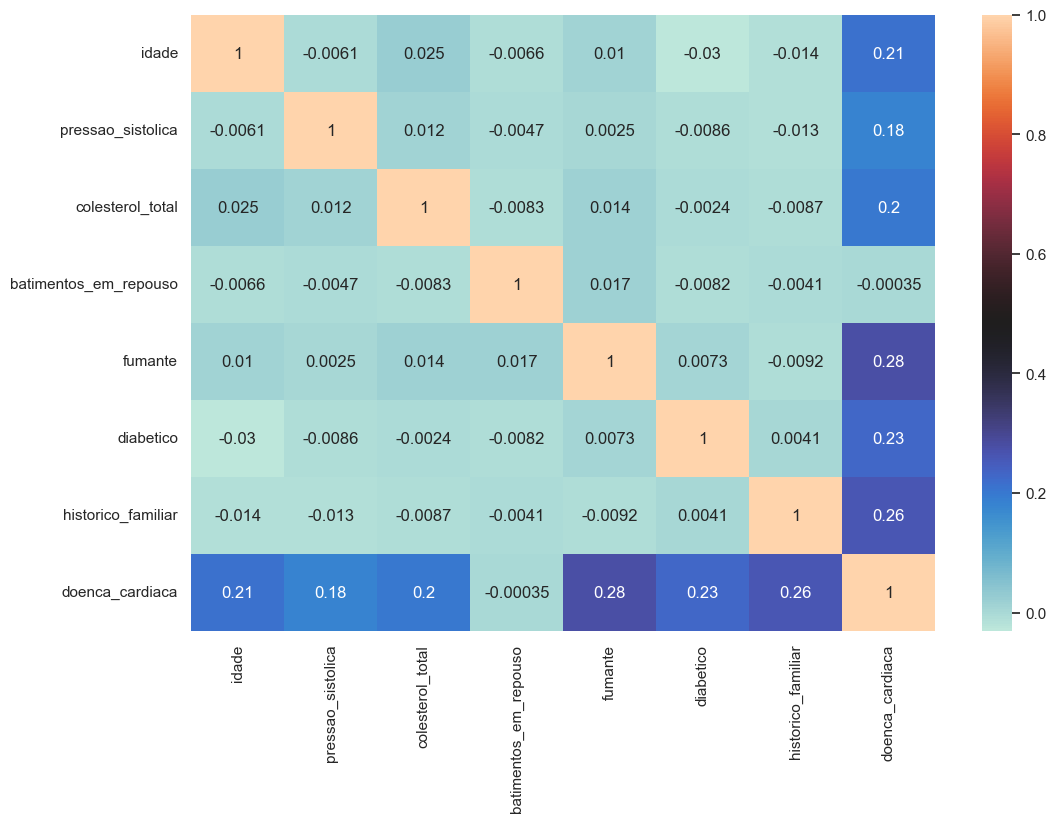

In [4]:
sns.set_theme(context='notebook', style='darkgrid', palette='muted')

plt.figure(figsize=(12, 8))
sns.heatmap(heart_data.corr(numeric_only=True), annot=True, cmap='icefire')
plt.show()

## Análise das Correlações

#### **Idade e Doença Cardíaca**
- **Correlação:** 0,21 (moderada)
- **Insight:** A idade tem uma correlação positiva com a presença de doença cardíaca. Isso significa que, conforme a idade aumenta, há uma tendência maior de desenvolver problemas cardíacos.

#### **Pressão Sistólica e Doença Cardíaca**
- **Correlação:** 0,18 (moderada)
- **Insight:** A pressão sistólica também apresenta correlação positiva com a doença cardíaca. Isso é esperado, pois a hipertensão é um fator de risco bem conhecido para doenças do coração.

#### **Colesterol Total e Doença Cardíaca**
- **Correlação:** 0,20 (moderada)
- **Insight:** O colesterol total tem uma correlação positiva com a presença de doença cardíaca, indicando que níveis elevados de colesterol podem estar associados ao risco de doenças cardíacas.

#### **Fumante e Doença Cardíaca**
- **Correlação:** 0,28 (moderada)
- **Insight:** O hábito de fumar tem uma correlação positiva considerável com a doença cardíaca, o que confirma o impacto negativo do fumo na saúde cardiovascular.

#### **Diabético e Doença Cardíaca**
- **Correlação:** 0,23 (moderada)
- **Insight:** A presença de diabetes tem uma correlação positiva com a doença cardíaca, sugerindo que pacientes diabéticos têm maior risco de desenvolver problemas cardíacos.

#### **Histórico Familiar e Doença Cardíaca**
- **Correlação:** 0,26 (moderada)
- **Insight:** A presença de histórico familiar de doenças cardíacas tem uma correlação moderada com a doença cardíaca, indicando a influência genética no risco de problemas cardíacos.

---

As variáveis com as maiores correlações com a doença cardíaca são **fumante**, **diabético**, **histórico familiar**, **pressão sistólica** e **colesterol total**. Essas variáveis devem ser destacadas como preditoras chave em modelos de machine learning. A presença de correlações moderadas sugere que essas variáveis têm um papel importante na previsão do risco de doenças cardíacas.


## Função `plot_subplots`

A função `plot_subplots` facilita a criação de múltiplos gráficos (subplots) em uma única figura. Ela foi criada para gerar rapidamente gráficos de diferentes tipos (histogramas, boxplots ou countplots) para várias colunas do dataset, sem necessidade de reescrever o código para cada um.

### Parâmetros:
- **nrows e ncols:** Definem o número de linhas e colunas de subplots.
- **width e height:** Tamanho da figura.
- **cols:** Lista das colunas para as quais os gráficos serão gerados.
- **plot_type:** Tipo de gráfico (`'hist'`, `'boxplot'` ou `countplot`).
- **hue:** Define a coluna que separa os dados por cor, destacando categorias.

In [5]:
def plot_subplots(nrows, ncols, width, height, cols, plot_type, hue=None):
    fig, ax = plt.subplots(nrows, ncols, figsize=(width, height))
    ax = ax.flatten()

    for i, col in enumerate(cols):
        if plot_type == 'hist':
            sns.histplot(data=heart_data, x=col, ax=ax[i], hue=hue)
            ax[i].set_title(col)
            ax[i].set_xlabel(None)

        elif plot_type == 'boxplot':
            sns.boxplot(data=heart_data, y=col, ax=ax[i], hue=hue)
            ax[i].set_title(col)
            ax[i].set_ylabel(None)
            
        else:
            sns.countplot(data=heart_data, x=col, ax=ax[i], hue=hue)
            ax[i].set_title(col)
            ax[i].set_xlabel(None)

    plt.tight_layout()
    plt.show()

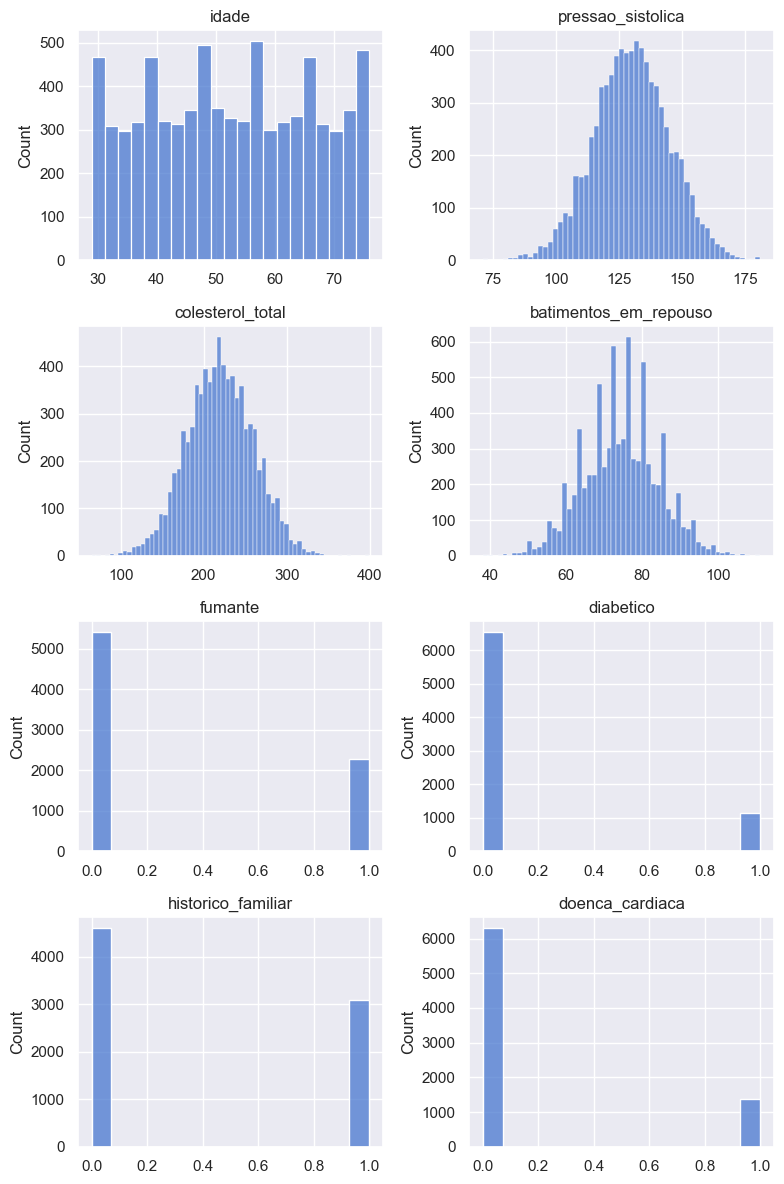

In [6]:
numericos = heart_data.select_dtypes(include=np.number).columns

plot_subplots(nrows=4, ncols=2, width=8, height=12, cols=numericos, plot_type='hist')

A partir dos histogramas gerados, podemos tirar várias conclusões sobre a distribuição das variáveis numéricas:

### Idade
- O histograma da idade apresenta uma distribuição relativamente uniforme, com picos em faixas etárias específicas. A distribuição não é totalmente simétrica, mas os indivíduos estão espalhados por diversas faixas etárias, com um número razoável de pessoas nas faixas mais baixas (30-40 anos) e mais altas (70+ anos).

- Isso sugere que o dataset abrange uma ampla gama de idades, com maior concentração em idades mais jovens e médias.

### Pressão Sistólica
- A distribuição da pressão sistólica segue uma forma normal (gaussiana), com um pico central em torno de 120-130 mmHg, o que indica que a maioria dos indivíduos tem pressão arterial dentro da faixa considerada normal (até 140 mmHg).

- Isso pode ser um indicativo de que a maioria das pessoas no dataset tem uma pressão arterial controlada ou saudável.

### Colesterol Total
- O colesterol total também segue uma distribuição que parece ser uma normal com picos em torno de 200-250 mg/dL.

- A distribuição sugere que a maioria dos indivíduos tem colesterol dentro de uma faixa considerada saudável, mas com uma parte significativa da população tendo valores mais elevados.

### Batimentos em Repouso
- O histograma dos batimentos em repouso apresenta uma distribuição aproximadamente normal, com uma leve assimetria e alguns picos discretos, principalmente em torno de 70 a 80 batimentos por minuto.

### Fumante
- O histograma da variável "fumante" mostra uma forte concentração de indivíduos que não fumam (valor 0), enquanto um número significativamente menor fuma (valor 1).

- Isso indica que a maioria dos indivíduos no dataset não é fumante, o que pode ser relevante para entender a correlação entre fumar e o risco de doenças cardíacas.

### Diabético
- A distribuição da variável "diabetico" também é desigual, com a maioria dos indivíduos não sendo diabéticos (valor 0) e apenas uma pequena parte sendo diabética (valor 1).

- Isso sugere que, embora a diabetes seja um fator de risco importante para doenças cardíacas, a maioria dos indivíduos no dataset não possui diabetes.

### Histórico Familiar
- A distribuição de "historico_familiar" é semelhante à das outras variáveis categóricas, com uma grande concentração de valores 0 (sem histórico familiar de doenças cardíacas) e uma menor quantidade de valores 1 (com histórico familiar).

- Isso sugere que, na população do dataset, a maior parte não tem histórico familiar de doenças cardíacas, mas a variável ainda assim tem importância na análise do risco.

### Doença Cardíaca
- A distribuição de "doenca_cardiaca" é muito desigual, com a maioria dos indivíduos no dataset não tendo doença cardíaca (valor 0), enquanto uma parte considerável tem (valor 1).

- Isso é esperado, já que doenças cardíacas são frequentemente mais raras, mas a distribuição desequilibrada pode afetar modelos de aprendizado de máquina, exigindo estratégias para lidar com o desbalanceamento de classes.

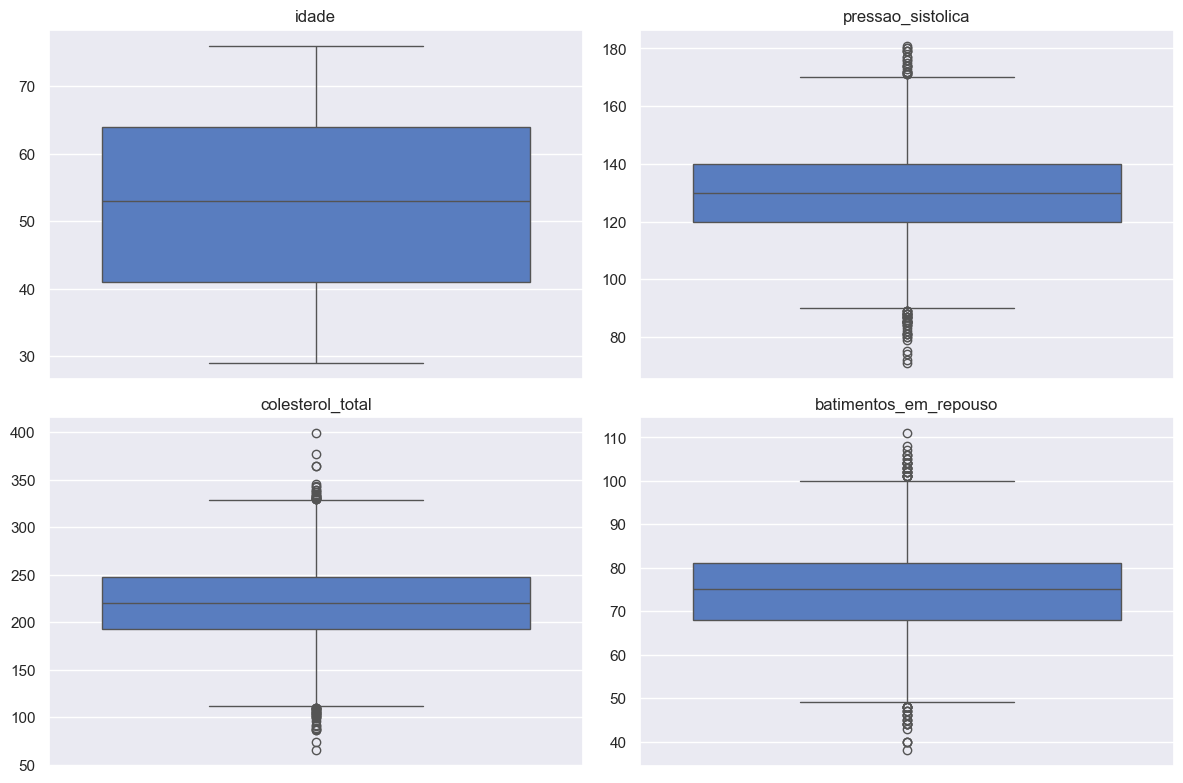

In [7]:
plot_subplots(nrows=2, ncols=2, width=12, height=8, 
              cols=['idade', 'pressao_sistolica', 'colesterol_total', 'batimentos_em_repouso'], 
              plot_type='boxplot')

## Análise dos Boxplots das Variáveis Numéricas Contínuas

### idade
- A distribuição da idade é relativamente simétrica.
- A mediana está próxima dos 53 anos.
- Não há outliers visíveis.

### pressao_sistolica
- A mediana está em torno de 130 mmHg.
- Há vários outliers, tanto para valores baixos quanto altos.
- A faixa interquartil está entre ~120 e ~140 mmHg.
- Os outliers inferiores indicam pressões muito baixas (hipotensão), e os superiores possíveis casos de hipertensão grave.

### colesterol_total
- A mediana está por volta de 220 mg/dL.
- Existem diversos outliers acima de 300 mg/dL, indicando níveis de colesterol total muito elevados.
- A faixa interquartil está entre ~190 e ~250 mg/dL.
- Os outliers reforçam a presença de indivíduos com risco cardiovascular elevado.

### batimentos_em_repouso
- A mediana está por volta de 75 bpm.
- A faixa interquartil está entre ~68 e ~82 bpm.
- Há outliers tanto abaixo de 50 quanto acima de 100 bpm.

---
As variáveis pressao_sistolica, colesterol_total e batimentos_em_repouso possuem outliers importantes, que devem ser analisados com cuidado.

A variável idade tem distribuição mais estável e sem outliers.

A presença de valores extremos pode afetar análises estatísticas e modelos preditivos, sendo útil considerar transformações ou tratamento de outliers.

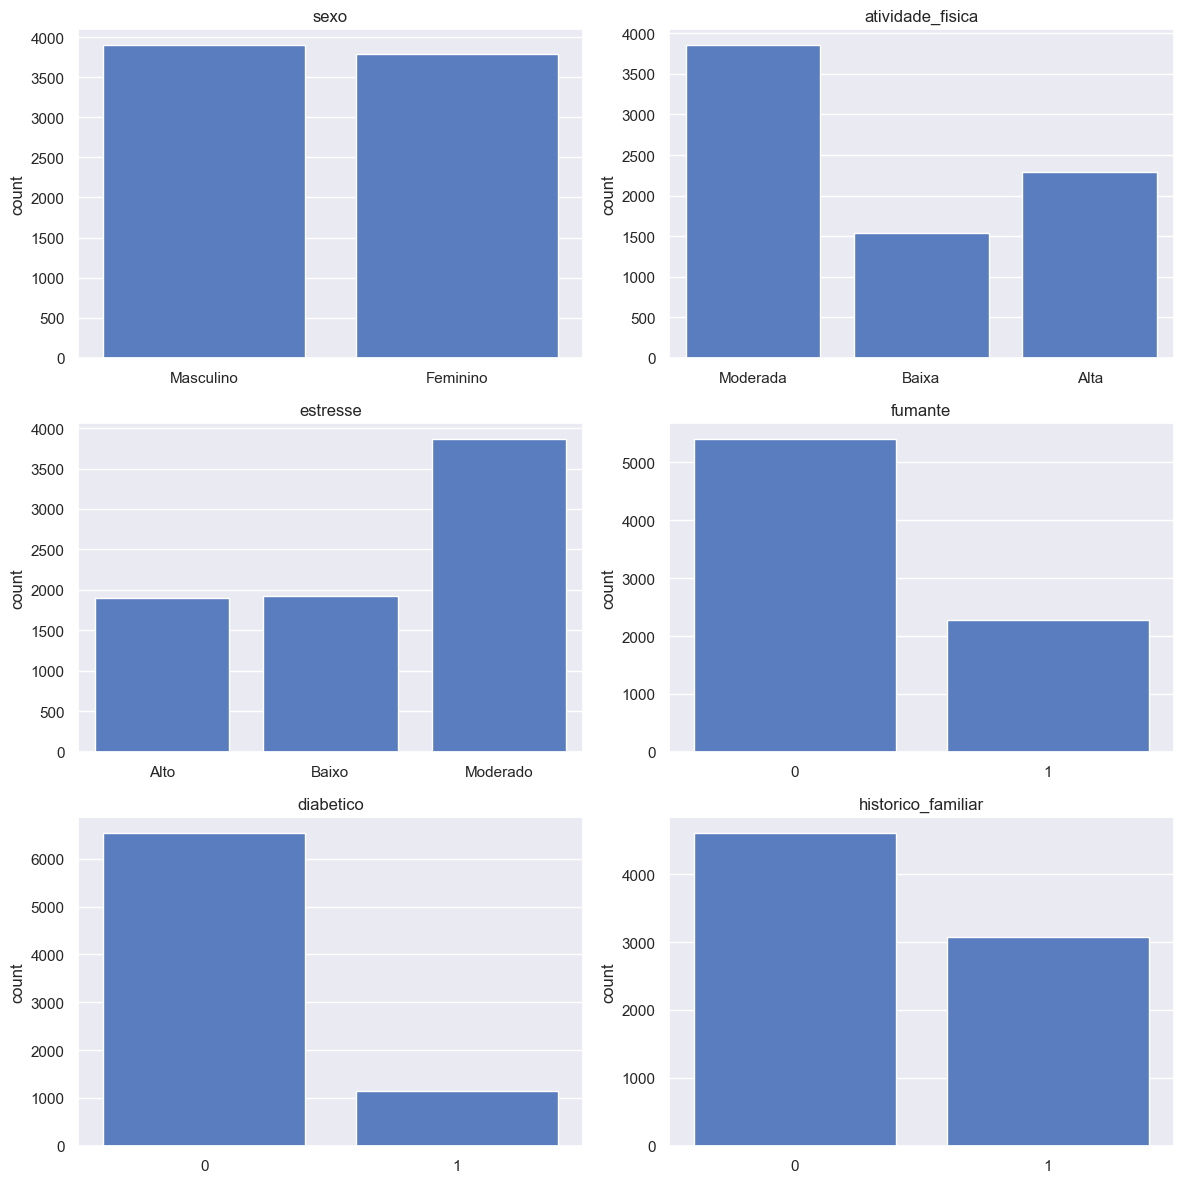

In [8]:
categoricas = heart_data.select_dtypes(exclude=np.number).columns.to_list()

plot_subplots(nrows=3, ncols=2, width=12, height=12, 
              cols=categoricas + ['fumante', 'diabetico', 'historico_familiar'], 
              plot_type='countplot')

## Análise das Variáveis Categóricas e Binárias

### sexo
- A distribuição entre homens e mulheres é equilibrada, com uma quantidade quase igual em ambas as categorias.

### atividade_fisica
- A maioria das pessoas pratica atividade física moderada.
- O grupo com baixa atividade física é o menor.
- A alta atividade física aparece como intermediária.

### estresse
- O número de pessoas com estresse alto e baixo é relativamente próximo.
- Há uma maior concentração de pessoas com estresse moderado, sendo a categoria dominante.

### fumante
- A maioria dos registros são de pessoas não fumantes.

### diabetico
- A variável está fortemente desbalanceada: a maioria não possui diabetes.
- Isso pode impactar análises de correlação e modelos preditivos, sendo necessário atenção para o desbalanceamento de classe.

### historico_familiar
- Há uma maior proporção de pessoas sem histórico familiar de doenças cardíacas.
- Ainda assim, a quantidade de pessoas com histórico familiar é considerável e pode influenciar nas análises.

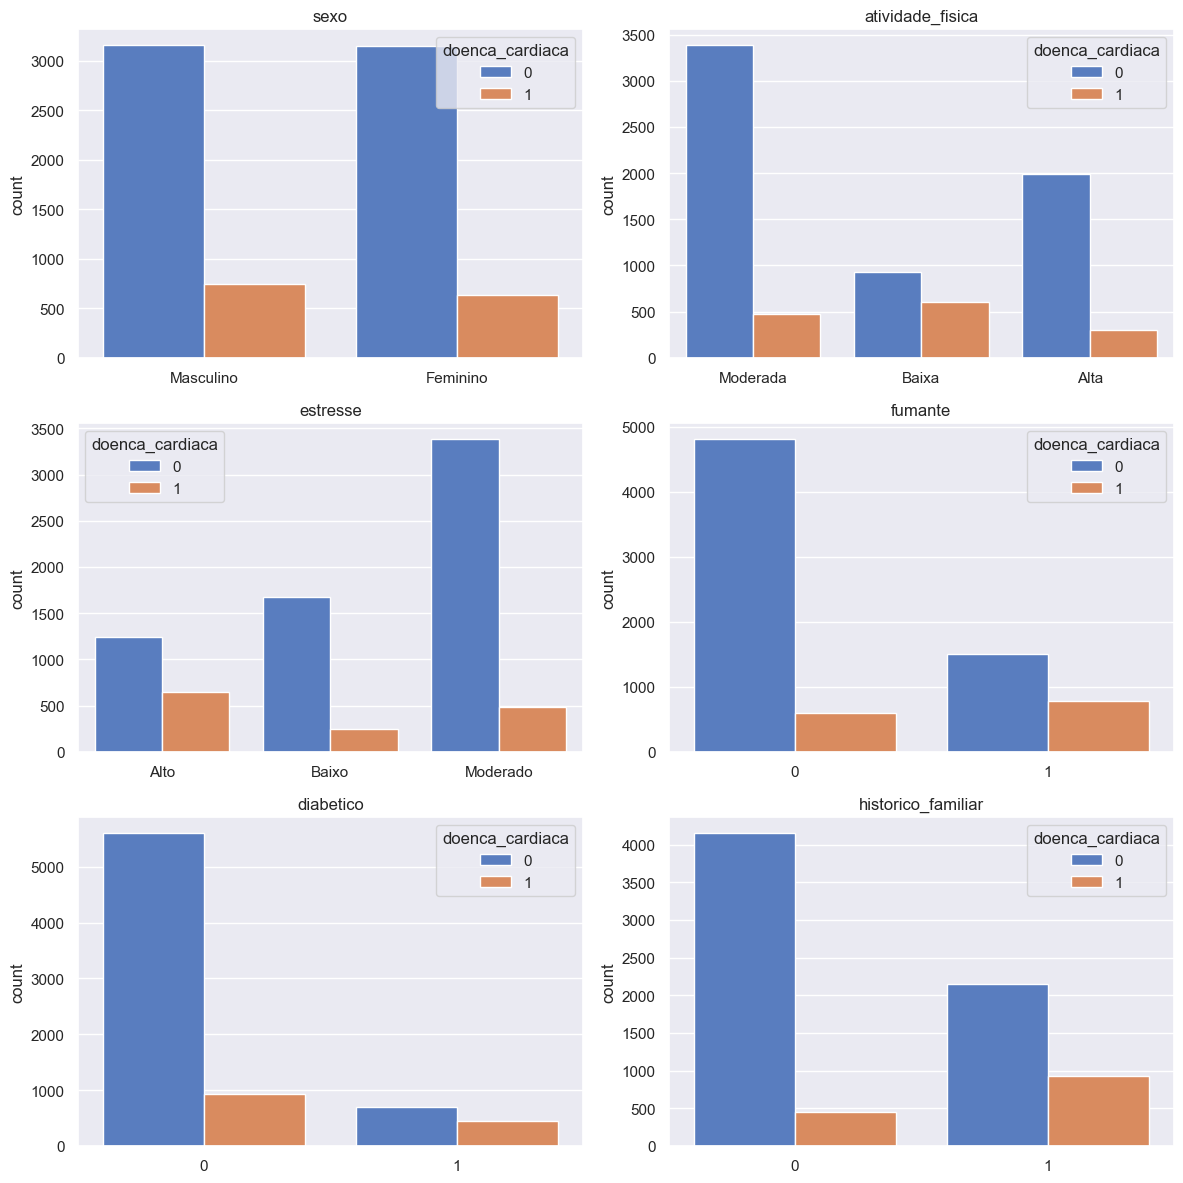

In [9]:
plot_subplots(nrows=3, ncols=2, width=12, height=12, 
              cols=categoricas + ['fumante', 'diabetico', 'historico_familiar'], 
              plot_type='countplot', hue='doenca_cardiaca')

### Análise das Variáveis Categóricas e Binárias em Relação à Doença Cardíaca

### sexo
- Há mais homens com doença cardíaca do que mulheres.
- Isso sugere que o sexo masculino pode estar mais associado ao risco de doenças cardíacas.

### atividade_fisica
- Indivíduos com atividade física moderada ou alta apresentam menos casos de doença cardíaca.
- Já os que têm baixa atividade física possuem uma proporção maior de casos com a doença.
- A prática de atividades físicas parece ser um fator de proteção contra doenças cardíacas.

### estresse
- Pessoas com alto estresse apresentam uma maior proporção de casos com doença cardíaca.
- Aqueles com estresse moderado ou baixo têm menos incidência.
- O controle do estresse pode ser relevante na prevenção de problemas cardíacos.

### fumante
- Fumantes possuem maior proporção de casos com doença cardíaca comparado aos não fumantes.
- Fumar mostra-se um fator de risco importante.

### diabetico
- Surpreendentemente, pessoas não diabéticas têm mais casos de doença cardíaca do que as diabéticas.
- Isso pode parecer contraditório, mas, como vimos anteriormente, essa coluna está bastante desbalanceada, o que influencia essa aparente inversão.

### historico_familiar
- Indivíduos com histórico familiar positivo têm uma proporção maior de doença cardíaca.
- Isso sugere uma possível influência genética.
---
Fatores como sexo masculino, baixa atividade física, alto estresse, fumar e histórico familiar mostram-se associados à maior presença de doenças cardíacas.

A variável diabetes apresenta uma inversão curiosa, que se deve principalmente ao desbalanceamento da classe.

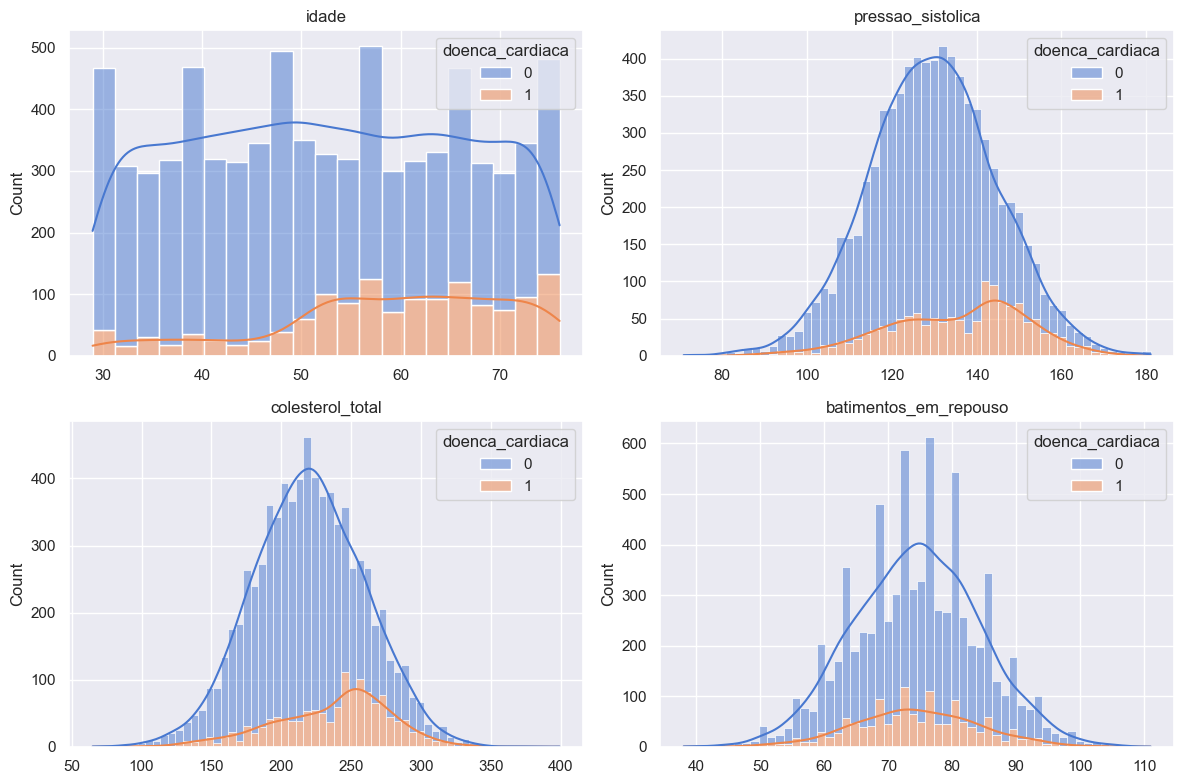

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.flatten()

for i, col in enumerate(['idade', 'pressao_sistolica', 'colesterol_total', 'batimentos_em_repouso']):
    sns.histplot(data=heart_data, x=col, hue='doenca_cardiaca', multiple='stack', kde=True, ax=ax[i])
    ax[i].set_title(col)
    ax[i].set_xlabel(None)

plt.tight_layout()
plt.show()

## Análise das Variáveis Numéricas Contínuas em Relação à Doença Cardíaca

### idade
- Pessoas com idades mais altas apresentam maior propensão a desenvolver doença cardíaca.
- A partir dos 50 anos, o número de casos com a doença aumenta significativamente.
- A idade é, portanto, um forte fator de risco.

### pressao_sistolica
- Indivíduos com pressão sistólica elevada têm maior incidência de doença cardíaca.
- Observa-se um pico claro de risco a partir de 140 mmHg.
- Isso reforça a ligação entre hipertensão e doenças cardíacas.

### colesterol_total
- A doença cardíaca está associada a níveis altos de colesterol.
- O risco se intensifica com valores acima de 250 mg/dL.
- Níveis elevados de colesterol total são um sinal de alerta clínico.

### batimentos_em_repouso
- Essa variável apresenta um comportamento irregular, com picos específicos principalmente no valor intermediário da distribuição.
- Pode haver uma relação com condições clínicas específicas, mas não mostra uma tendência tão clara quanto as demais.
- Vale a pena uma análise mais profunda para entender os padrões cardíacos em repouso.

As variáveis idade, pressao_sistolica e colesterol_total possuem associação positiva clara com a presença de doença cardíaca.

A variável batimentos_em_repouso exige exploração mais detalhada por não apresentar uma tendência contínua evidente.

In [11]:
X = heart_data.drop("doenca_cardiaca", axis=1)
y = heart_data['doenca_cardiaca']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
print(f"Tamanho do conjunto de treino: {X_train.shape[0]}")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]}")

Tamanho do conjunto de treino: 6148
Tamanho do conjunto de teste: 1537


## Codificação de Variáveis Categóricas com One-Hot Encoding

Nesta etapa, aplicamos o **One-Hot Encoding** para transformar as variáveis categóricas em variáveis numéricas. Isso é necessário porque a maioria dos algoritmos de machine learning não consegue lidar diretamente com dados categóricos — eles exigem variáveis numéricas para realizar os cálculos.

O **OneHotEncoder**, da biblioteca `sklearn.preprocessing`, cria **colunas binárias (0 ou 1)** para cada categoria possível das variáveis categóricas. Por exemplo, uma variável como `sexo` com as categorias `Masculino` e `Feminino` é transformada em duas colunas: `sexo_Masculino` e `sexo_Feminino`.

In [12]:
categoricas

['sexo', 'atividade_fisica', 'estresse']

In [13]:
encoder = OneHotEncoder(sparse_output=False, dtype=np.int32)
encoded_train = encoder.fit_transform(X_train[categoricas])
colunas = encoder.get_feature_names_out()
df_encoded_train = pd.DataFrame(encoded_train, columns=colunas)
X_train_final = pd.concat([X_train.drop(columns=categoricas).reset_index(drop=True), df_encoded_train], axis=1)
X_train_final.head()

,idade,pressao_sistolica,colesterol_total,batimentos_em_repouso,fumante,diabetico,historico_familiar,sexo_Feminino,sexo_Masculino,atividade_fisica_Alta,atividade_fisica_Baixa,atividade_fisica_Moderada,estresse_Alto,estresse_Baixo,estresse_Moderado
0,50,134,104,67,0,0,1,0,1,0,0,1,0,0,1
1,46,129,131,70,1,0,0,1,0,0,0,1,0,0,1
2,75,152,247,70,0,0,0,0,1,0,0,1,0,0,1
3,73,126,188,88,0,0,0,0,1,1,0,0,1,0,0
4,33,118,187,78,1,0,0,1,0,0,0,1,1,0,0


In [14]:
y_train.value_counts()

doenca_cardiaca
0    5046
1    1102
Name: count, dtype: int64

In [15]:
y_train.value_counts(normalize=True)

doenca_cardiaca
0    0.820755
1    0.179245
Name: proportion, dtype: float64

## Treinamento e Avaliação de Modelos

Nesta etapa, estamos implementando e avaliando três modelos de classificação:

- **Regressão Logística**
- **Random Forest**
- **Support Vector Classifier (SVC)**

O objetivo é comparar o desempenho desses modelos na predição da variável alvo (`doenca_cardiaca`).

### O que está sendo feito:

1. **Treinamento dos modelos**: Cada modelo é treinado com os dados de treino balanceados pelo SMOTE.
2. **Predições**: Realizamos as previsões com os dados de teste.
3. **Avaliação**: Calculamos a acurácia, a matriz de confusão e o relatório de classificação (precision, recall e f1-score) para cada modelo.
4. **Armazenamento dos resultados**: Os resultados de cada modelo são salvos em um dicionário para facilitar comparações posteriores.

Ao final, teremos uma visão clara de qual modelo se sai melhor na tarefa de classificação da presença de doença cardíaca.


In [16]:
encoded_test = encoder.transform(X_test[categoricas])
df_encoded_test = pd.DataFrame(encoded_test, columns=colunas)
X_test_final = pd.concat([X_test.drop(columns=categoricas).reset_index(drop=True), df_encoded_test], axis=1)
X_test_final.head()

,idade,pressao_sistolica,colesterol_total,batimentos_em_repouso,fumante,diabetico,historico_familiar,sexo_Feminino,sexo_Masculino,atividade_fisica_Alta,atividade_fisica_Baixa,atividade_fisica_Moderada,estresse_Alto,estresse_Baixo,estresse_Moderado
0,62,162,231,87,0,0,0,0,1,1,0,0,0,1,0
1,56,135,313,67,0,0,0,0,1,0,0,1,0,1,0
2,35,121,188,80,1,0,0,0,1,1,0,0,1,0,0
3,67,153,255,76,0,0,1,0,1,1,0,0,0,0,1
4,56,129,177,72,0,0,1,1,0,0,0,1,0,0,1


Eu também vou aplicar o `StandardScaler` para padronizar os dados, pois alguns modelos de machine learning, como o SVC (Support Vector Classifier), são sensíveis à escala das variáveis.

O `StandardScaler` transforma os dados para que tenham média 0 e desvio padrão 1.

É importante ressaltar que StandardScaler deve ser aplicado apenas às variáveis numéricas contínuas (idade, pressão arterial, colesterol) e NÃO às variáveis binárias (0 e 1). As variáveis binárias já estão em uma escala adequada e padronizá-las distorceria seu significado e poderia prejudicar o desempenho do modelo.

In [17]:
scaler = StandardScaler()

colunas_numericas = ['idade', 'pressao_sistolica', 'colesterol_total', 'batimentos_em_repouso']

X_train_final[colunas_numericas] = scaler.fit_transform(X_train_final[colunas_numericas])
X_train_final.head()

,idade,pressao_sistolica,colesterol_total,batimentos_em_repouso,fumante,diabetico,historico_familiar,sexo_Feminino,sexo_Masculino,atividade_fisica_Alta,atividade_fisica_Baixa,atividade_fisica_Moderada,estresse_Alto,estresse_Baixo,estresse_Moderado
0,-0.187021,0.295110,-2.901278,-0.761461,0,0,1,0,1,0,0,1,0,0,1
1,-0.476498,-0.039379,-2.223434,-0.456135,1,0,0,1,0,0,0,1,0,0,1
2,1.622212,1.499273,0.688789,-0.456135,0,0,0,0,1,0,0,1,0,0,1
3,1.477473,-0.240073,-0.792428,1.375820,0,0,0,0,1,1,0,0,1,0,0
4,-1.417299,-0.775256,-0.817533,0.358068,1,0,0,1,0,0,0,1,1,0,0


In [18]:
X_test_final[colunas_numericas] = scaler.transform(X_test_final[colunas_numericas])
X_test_final.head()

,idade,pressao_sistolica,colesterol_total,batimentos_em_repouso,fumante,diabetico,historico_familiar,sexo_Feminino,sexo_Masculino,atividade_fisica_Alta,atividade_fisica_Baixa,atividade_fisica_Moderada,estresse_Alto,estresse_Baixo,estresse_Moderado
0,0.681411,2.168252,0.287103,1.274045,0,0,0,0,1,1,0,0,0,1,0
1,0.247195,0.362008,2.345743,-0.761461,0,0,0,0,1,0,0,1,0,1,0
2,-1.272560,-0.574563,-0.792428,0.561618,1,0,0,0,1,1,0,0,1,0,0
3,1.043258,1.566171,0.889632,0.154517,0,0,1,0,1,1,0,0,0,0,1
4,0.247195,-0.039379,-1.068587,-0.252584,0,0,1,1,0,0,0,1,0,0,1


In [19]:
modelos = {'regressao_logistica': LogisticRegression(),
          'random_forest': RandomForestClassifier(),
          'SVC': SVC()}

resultados = defaultdict(list)

for nome_modelo, modelo in modelos.items():
    modelo.fit(X_train_final, y_train)
    pred = modelo.predict(X_test_final)
    accuracy = accuracy_score(y_test, pred)
    confusion_m = confusion_matrix(y_test, pred)
    classification_r = classification_report(y_test, pred)

    resultados[nome_modelo].append((accuracy, confusion_m, classification_r))

print("modelos treinados.")

modelos treinados.


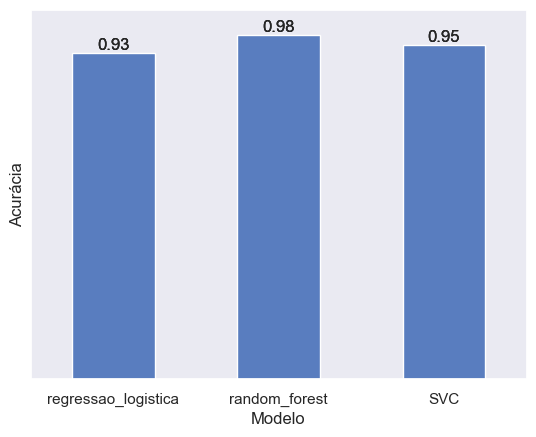

In [20]:
acuracia_modelos = {nome_modelo: resultado[0][0] for nome_modelo, resultado in resultados.items()}
barras = sns.barplot(x=acuracia_modelos.keys(), y=acuracia_modelos.values(), width=0.5)
for barra in barras.containers[0]:
    altura = barra.get_height()
    barras.bar_label(barras.containers[0], fmt='%.2f')
plt.yticks([])
plt.xlabel("Modelo")
plt.ylabel("Acurácia")
plt.ylim(0, 1.05)
plt.show()

Parece que o Random Forest foi o que teve um acurácia maior, de 98%. Antes de escolher esse como o modelo final, vamos analisar outras métricas para cada um dos modelos:

In [21]:
for nome_modelo, resultado in resultados.items():
    print(f"Avaliação do modelo {nome_modelo}:")
    print(f"Acurácia: {resultado[0][0]:.2%}")
    print(f"Matriz de confusão:\n{resultado[0][1]}")
    print(f"Classification report:\n{resultado[0][2]}\n\n")

Avaliação do modelo regressao_logistica:
Acurácia: 92.65%
Matriz de confusão:
[[1214   47]
 [  66  210]]
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1261
           1       0.82      0.76      0.79       276

    accuracy                           0.93      1537
   macro avg       0.88      0.86      0.87      1537
weighted avg       0.92      0.93      0.93      1537



Avaliação do modelo random_forest:
Acurácia: 97.79%
Matriz de confusão:
[[1260    1]
 [  33  243]]
Classification report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1261
           1       1.00      0.88      0.93       276

    accuracy                           0.98      1537
   macro avg       0.99      0.94      0.96      1537
weighted avg       0.98      0.98      0.98      1537



Avaliação do modelo SVC:
Acurácia: 95.06%
Matriz de confusão:
[[1236   25]
 [  51  225]]
Cla

O modelo Random Forest foi o que apresentou o melhor desempenho entre os modelos testados, com uma acurácia de 97,79%. Isso significa que ele acertou a grande maioria das previsões no conjunto de teste.

Para ter certeza de que nenhum modelo está sofrendo overfitting, vamos aplicar a validação cruzada com 8 folds. Esse processo divide o conjunto de treino em 8 partes, onde o modelo é treinado em 7 e testado na parte restante, repetindo isso 8 vezes. Assim, consigo avaliar a performance média dos modelos em diferentes divisões dos dados, garantindo resultados mais confiáveis e estáveis.

In [22]:
resultados_cross_val = defaultdict(list)

for nome_modelo, modelo in modelos.items():
    scores = cross_val_score(modelo, X_train_final, y_train, cv=8, scoring='accuracy', n_jobs=-1)
    resultados_cross_val[nome_modelo].append(scores)

print("modelos treinados.")

modelos treinados.


In [23]:
for nome_modelo, resultado in resultados_cross_val.items():
    print(f"scores para o modelo {nome_modelo}:\n{resultado}")
    print(f"score médio: {resultado[0].mean():.2%}")
    print(f"desvio padrão: {resultado[0].std()}\n\n")

scores para o modelo regressao_logistica:
[array([0.93498049, 0.94278283, 0.92847854, 0.91677503, 0.94401042,
       0.95572917, 0.9375    , 0.93359375])]
score médio: 93.67%
desvio padrão: 0.010784170072072293


scores para o modelo random_forest:
[array([0.98569571, 0.98179454, 0.97139142, 0.97269181, 0.97135417,
       0.97265625, 0.97265625, 0.97916667])]
score médio: 97.59%
desvio padrão: 0.005168359280634469


scores para o modelo SVC:
[array([0.95968791, 0.95838752, 0.95448635, 0.93758127, 0.95572917,
       0.95833333, 0.9609375 , 0.9609375 ])]
score médio: 95.58%
desvio padrão: 0.007199449263469039




Mais uma vez, o Random Forest se mostrou superior. Vamos analisar ele com mais detalhes agora.

In [24]:
rf = modelos['random_forest']
cm_rf = resultados['random_forest'][0][1]
classification_rf = resultados['random_forest'][0][2]

In [25]:
print(classification_rf)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1261
           1       1.00      0.88      0.93       276

    accuracy                           0.98      1537
   macro avg       0.99      0.94      0.96      1537
weighted avg       0.98      0.98      0.98      1537



O relatório de classificação mostra que o modelo apresenta um desempenho excelente. Para a classe "1" (pessoas com doença cardíaca), temos precision de 1.00 e recall de 0.88, o que indica que o modelo identificou corretamente todos os casos que ele previu como positivos, mas deixou de identificar cerca de 12% dos reais casos positivos. Isso é algo a se observar, especialmente em contextos médicos, onde falsos negativos podem ter consequências graves.

Por outro lado, o modelo se saiu excepcionalmente bem na classe "0" (pessoas saudáveis), com precision de 0.97 e recall de 1.00, ou seja, praticamente nenhum caso saudável foi classificado erroneamente como doente (falso positivo).

As métricas médias também reforçam a robustez do modelo: o f1-score ponderado é 0.98, o que mostra um excelente equilíbrio entre precisão e recall considerando o desequilíbrio entre as classes (1261 vs 276). A média macro do F1-score (0.96) mostra que o modelo tem um bom desempenho em ambas as classes, sem favorecer excessivamente a mais representada.

Esses resultados indicam que o modelo é altamente confiável para detectar corretamente casos de doença cardíaca, mantendo uma taxa muito baixa de alarmes falsos em pessoas saudáveis. Uma possível melhoria seria aumentar ainda mais o recall da classe positiva, caso o objetivo seja minimizar ao máximo os falsos negativos.

<Figure size 600x400 with 0 Axes>

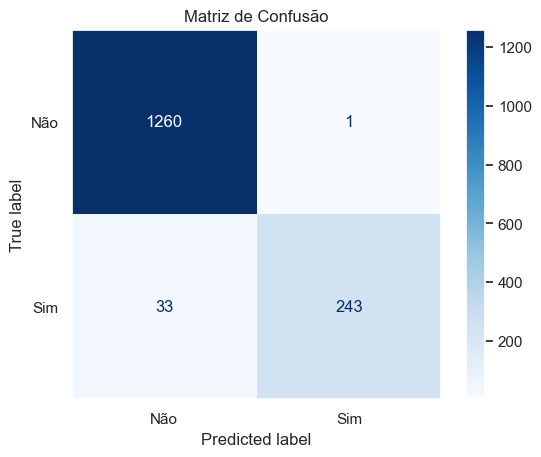

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Não', 'Sim'])

plt.figure(figsize=(6, 4))
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão')
plt.grid(False)
plt.show()

Podemos ver que o modelo classificou corretamente 1260 pessoas sem doença cardíaca e 243 pessoas com doença cardíaca. Os erros foram relativamente baixos e concentrados em apenas um tipo: 36 falsos negativos, ou seja, 33 pessoas com a doença foram classificadas como saudáveis.

Outro ponto positivo é que houve apenas 1 falso positivo, 1 pessoa saudável foi classificada erroneamente como doente, o que reforça a alta precisão para a classe negativa (saudáveis). Por outro lado, os falsos negativos indicam que ainda há margem para melhorar o recall da classe positiva, algo importante em contextos médicos para evitar deixar casos reais sem tratamento.

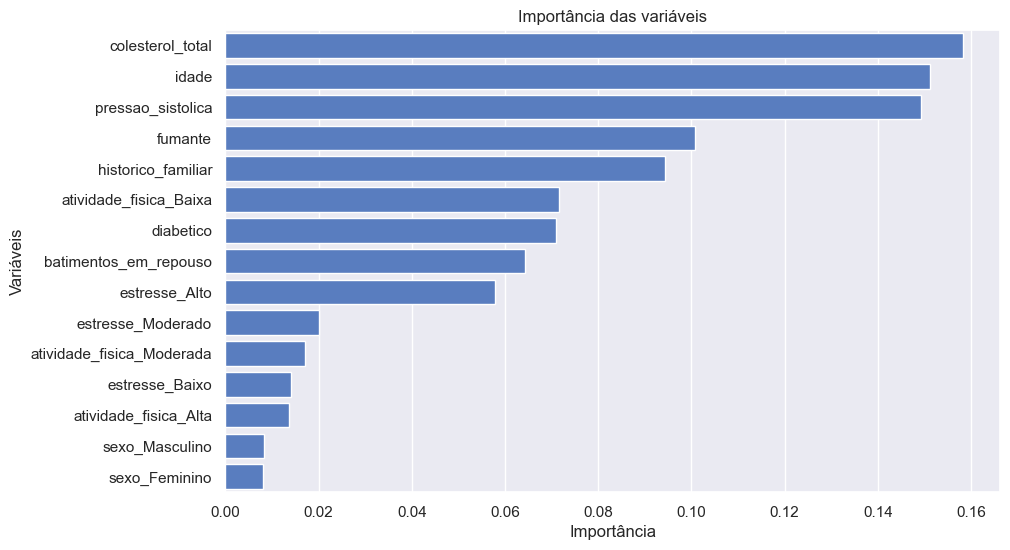

In [27]:
features = pd.Series(rf.feature_importances_, index=X_train_final.columns)
features.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(y=features.index, x=features.values)
plt.title("Importância das variáveis")
plt.xlabel("Importância")
plt.ylabel("Variáveis")
plt.show()

A análise das importâncias das variáveis no modelo Random Forest revela insights valiosos sobre os fatores que mais influenciam a presença de doença cardíaca.

As variáveis mais relevantes foram:

- **colesterol_total**, **Idade**, e **pressao_sistolica** estão no topo da lista, o que faz sentido clinicamente, pois são fatores clássicos de risco cardiovascular.
- **Histórico familiar** e **fumante** também aparecem com grande importância, reforçando a influência de fatores hereditários e hábitos de vida na saúde cardíaca.
- **Atividade física baixa** e **diabetes** mostram peso considerável, indicando que estilo de vida e condições crônicas afetam significativamente o risco.
- Variáveis como **estresse**, **batimentos em repouso** e **sexo** tiveram menor influência, mas ainda assim contribuem para o modelo.

Esses resultados fazem total sentido, já era de se esperar depois da nossa análise exploratória.

Aqui analisaremos a curva ROC (Receiver Operating Characteristic).

Ela mostra a relação entre a taxa de verdadeiros positivos (sensibilidade) e a taxa de falsos positivos, ajudando a entender a performance do modelo em diferentes thresholds de decisão. O AUC (Área sob a curva) resume essa performance: quanto mais próximo de 1, melhor.

In [28]:
y_prob = rf.predict_proba(X_test_final)[:, 1]

auc_score = roc_auc_score(y_test, y_prob)
auc_score

np.float64(0.9995445873415394)

Com um AUC score de 0.99, podemos concluir que o modelo tem uma capacidade altíssima de separação entre as classes “sim” e “não” (doença cardíaca).

Isso significa que, independentemente do threshold usado, o modelo está classificando quase perfeitamente os casos positivos e negativos.


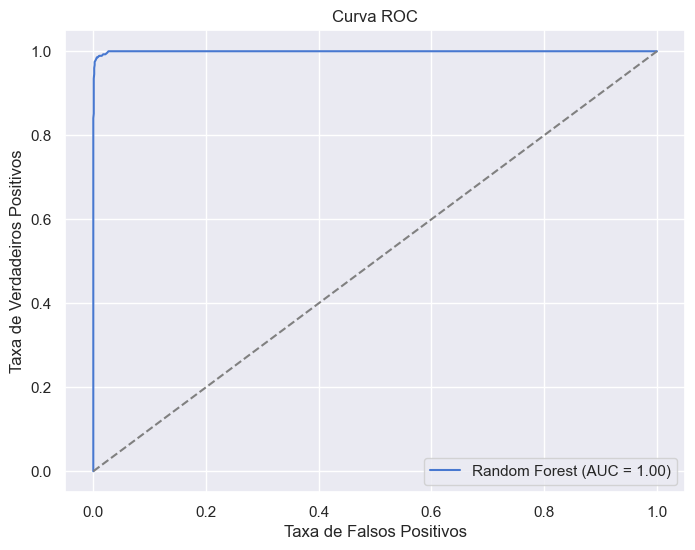

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

A curva ROC do modelo Random Forest mostra uma performance excelente, com a curva se aproximando do canto superior esquerdo, o que indica alta taxa de verdadeiros positivos com baixa taxa de falsos positivos. O valor de AUC (0.99) confirma que o modelo tem uma capacidade quase perfeita de distinguir entre as classes. Isso reforça a robustez do modelo e a ausência de overfitting, já que o desempenho nos dados de teste também é muito alto.


Nesta etapa, poderíamos realizar o fine-tuning do nosso modelo, buscando os melhores valores para os hiperparâmetros. No entanto, está mais do que claro que o nosso modelo está impecável. Com uma acurácia de 97% nos dados de teste e uma curva ROC quase perfeita, o ajuste fino poderia inclusive levar ao overfitting prejudicando a generalização do modelo.

Portanto, finalizamos nosso projeto aqui. Conseguimos criar um modelo de Random Forest robusto, capaz de prever com alta precisão se uma pessoa possui ou não doença cardíaca

Este projeto demonstra, na prática, como o machine learning pode ser uma ferramenta poderosa para ajudar na área da saúde oferecendo suporte à tomada de decisão médica com base em dados.


In [30]:
joblib.dump(rf, "modelo_random_forest.joblib")
joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']